In [1]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from statistics import pstdev
from scipy.fft import fftshift, ifft, fftfreq
import numpy as np
from scipy.signal.windows import tukey
import math
from scipy.interpolate import interp1d
from time import time as time
from time import strftime
from datetime import date
from scipy.signal import ShortTimeFFT
from scipy.signal import find_peaks, peak_widths
from scipy.stats import norm
from IPython.display import display, Latex
import re 
from scipy import optimize
from matplotlib.patches import Rectangle
from scipy.interpolate import PchipInterpolator
import lmfit

from scipy.signal.windows import tukey

plt.rcParams.update({'font.size':13})

## Useful functions 

In [2]:
def FWHM(x,y):

    peak_centre =[]
    unit_widths=[]
    full_width_half_max=[]
    lefts_unit =[]
    rights_unit=[]
    lefts =[]
    rights=[]
    heights=[]
    
    dx = np.mean(np.diff(x))

    #print(dx)

    
    
    

    peak,peak_heights = find_peaks(y,distance =2,prominence= 0.3*np.max(y), height = 0.75)

    peak_y = peak_heights["peak_heights"]

    heights.append(peak_y)

    peak_centre.append(peak[0])

    widths =  peak_widths(y, peak_centre, rel_height =0.5)  

    #print(widths)
    
    unit_widths.append(widths[0])
    lefts_unit.append(widths[2])
    rights_unit.append(widths[3])

    for i in range(len(unit_widths)):

        fwhm = unit_widths[i] * dx
        #print(fwhm)
        left_pos = lefts_unit[i] *dx    
        right_pos = rights_unit[i] *dx   
        full_width_half_max.append(fwhm)
        lefts.append(left_pos)
        rights.append(right_pos)

   
    

    '''
    for i in range(len(full_width_half_max)):

        print('The peak has a FWHM of {0:.3f}fs with a LH crossing of {1:.3f}fs and a RH crossing of {2:.3f}fs'.format(float(full_width_half_max[i]), float(lefts[i]), float(rights[i])) ) 

    '''
    return full_width_half_max, lefts, rights, heights, dx, fwhm

def FWHM_2(x,y):
    peak =np.argmax(y)
    peak_val =y[peak]
    half_max = peak_val /2 

    # Left side
    left_region = y[:peak]
    if np.any(left_region <= half_max):
        y1 = np.where(left_region <= half_max)[0][-1]
        y0 = y1 + 1
        # linear interpolation for crossing
        x_left = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    else:
        return np.nan

    # Right side
    right_region = y[peak:]
    if np.any(right_region <= half_max):
        y1 = np.where(right_region <= half_max)[0][0] + peak
        y0 = y1 - 1
        x_right = x[y1] + (x[y0] - x[y1]) * (half_max - y[y1]) / (y[y0] - y[y1])
    else:
        return np.nan

    fwhm = x_right -x_left
    return fwhm
    

    


def FWHM(t, I):
    # Find peak
    peak = np.argmax(I)
    peak_val = I[peak]
    half = peak_val / 2

    # Left side
    left_region = I[:peak]
    if np.any(left_region <= half):
        i1 = np.where(left_region <= half)[0][-1]
        i0 = i1 + 1
        # linear interpolation for crossing
        t_left = t[i1] + (t[i0] - t[i1]) * (half - I[i1]) / (I[i0] - I[i1])
    else:
        return np.nan

    # Right side
    right_region = I[peak:]
    if np.any(right_region <= half):
        i1 = np.where(right_region <= half)[0][0] + peak
        i0 = i1 - 1
        t_right = t[i1] + (t[i0] - t[i1]) * (half - I[i1]) / (I[i0] - I[i1])
    else:
        return np.nan

    return t_right - t_left

def quad_func(x,a,b,c,d,e):
    y = a*x**4 + b*x**3 + c*x**2 +d*x + e 
    return y    

def linear_func(x,m,c):
    y=m*x +c 
    return y
def GDD_from_time(target,p1,p2):

    GDD = (target -p2)/p1
    print('The GDD for a target pulse width of {0}fs is {1:.3f} fs^2'.format(target,GDD))
    return GDD

def time_from_GDD(target,p1,p2):
    tau = (p1*target) + p2
    print('The time for a target GDD of {0}fs^2 is {1:.3f} fs'.format(target,tau))
    return tau 

def gdd_from_time_poly(target,c5,c4,c3,c2,c1,c0,first_width):
    if target <= first_width: 
        target = first_width
        print('You have reached the TL limit of this pulse - the Target FWHM has been set to the TL limit')
        GDD = 0
        print('The GDD for a target pulse width of {0:.3f}fs is {1:.3f} fs^2'.format(target,GDD))
    else:
        GDD = c5*target**5 + c4*target**4 +c3*target**3 + c2*target**2 +c1*target + c0
        print('The GDD for a target pulse width of {0}fs is {1:.3f} fs^2'.format(target,GDD))
    return GDD

def time_from_GDD_poly(target,c5,c4,c3,c2,c1,c0,first_width):
    if target <= 0:
        
        print('You have reached the lower bound for this model hence we recover TL pulse')
        tau = first_width
        print('The time for a target GDD of {0}fs^2 is {1:.3f} fs'.format(target,tau))
    else: 
        tau = c5*target**5 + c4*target**4 +c3*target**3 + c2*target**2 +c1*target + c0
        print('The time for a target GDD of {0}fs^2 is {1:.3f} fs'.format(target,tau))
    return tau 

## Test the Phase Function on a laser spectrum 

First we need to simulate a laser spectrum or preferentially load one from file. We have the phase in the frequency domain therefore if we combine that with the laser spectrum in the frewuency domain (convolution??) and then FFT into the time domain we can see the effect of the phase. 

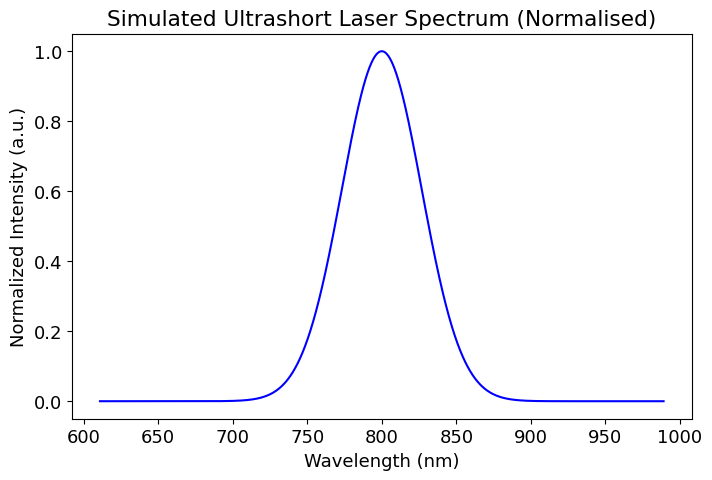

In [3]:


# --- Parameters ---
lambda0 = 800.0  # central wavelength (nm)
full_width_half = 63    # spectral FWHM (nm)
num_points = 200000


# the following commented out code I belive is non-centered I do not want to delete it just yet incase I need to get it back 
'''
# Wavelength range (cover at least ±3σ)
lambda_min = lambda0 - 3* full_width_half
lambda_max = lambda0 + 3* full_width_half
lambdas = np.linspace(lambda_min, lambda_max, num_points)

# --- Gaussian spectrum ---
def gaussian_spectrum(lambdas, lambda0, fwhm):
    """Return normalized Gaussian spectral intensity."""
    sigma = fwhm / (2*np.sqrt(2*np.log(2)))  # convert FWHM to std dev
    intensity = np.exp(-0.5 * ((lambdas - lambda0) / sigma)**2)
    return intensity / np.max(intensity)

I_lambda = gaussian_spectrum(waves, lambda0, full_width_half)
'''
lambdas = np.linspace(lambda0 - 3*full_width_half, lambda0 + 3*full_width_half, num_points)
sigma = full_width_half / (2*np.sqrt(2*np.log(2)))
I_lambda = np.exp(-0.5 * ((lambdas - lambda0) / sigma)**2)
A_lambda = np.sqrt(I_lambda / np.max(I_lambda))






# --- Normalize ---
I_lambda /= np.max(I_lambda)
A_lambda = np.sqrt(I_lambda / np.max(I_lambda))  # amplitude


# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(lambdas, I_lambda, color='blue')
plt.title("Simulated Ultrashort Laser Spectrum (Normalised)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Intensity (a.u.)")
#plt.xlim(lambda_min, lambda_max)
#plt.grid(alpha=0.3)
#plt.tight_layout()
plt.show()



### Convert to angular freqeuncy

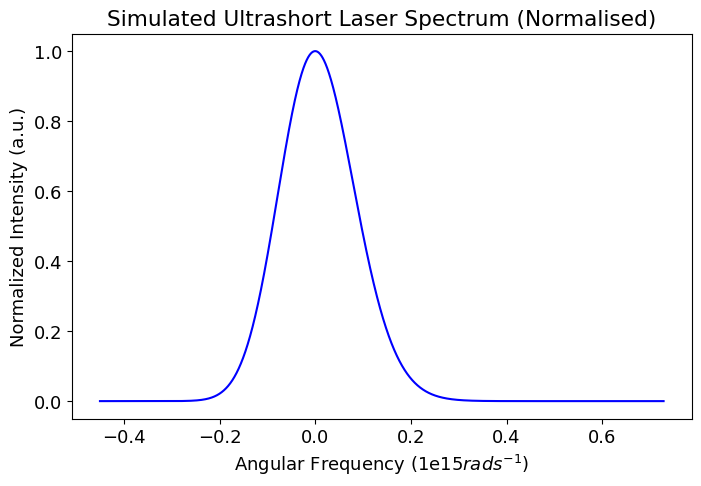

In [4]:
# Convert to angular frequency domain
c = 2.998e8  # m/s
omega = (2*np.pi*c / (lambdas * 1e-9))/1e15
omega0 = (2*np.pi*c / (lambda0 * 1e-9))/1e15
Omega = omega - omega0  # detuning from central frequency

# Sort ascending for Fourier compatibility
idx = np.argsort(Omega)
omegas, I_omega = Omega[idx], I_lambda[idx]

plt.figure(figsize=(8,5))
plt.plot(omegas, I_omega, color='blue')
plt.title("Simulated Ultrashort Laser Spectrum (Normalised)")
plt.xlabel("Angular Frequency (1e15$rads^{-1})$")
plt.ylabel("Normalized Intensity (a.u.)")
#plt.xlim(lambda_min, lambda_max)
#plt.grid(alpha=0.3)
#plt.tight_layout()
plt.show()

### Re-load the phase mask and convert it to angular freqeuncy

The First Cell is the loadding of the  real phase data

In [5]:
#phase_mask = np.loadtxt(title, delimiter =',')    # load the phase mask generated earlier in the file 

##phase_data =phase_mask[:,1]



#phase_data = summation[idx]



the second cell is the generation of simulated phase data

In [6]:

# --- Apply GDD (second-order phase) ---
a2 = 885 # s^2, adjust to see broadening
phase_data = -(a2 * (Omega)**2)  # 

### create evenly spaced omega grid for the FFT

In [7]:
# Create evenly spaced ω grid for FFT
delta_omega = (Omega.max()-Omega.min())/num_points
Omega_uniform = Omega.min() + np.arange(num_points) *delta_omega
#Omega_uniform = np.linspace(Omega.min(), Omega.max(), num_points)
A_interp = interp1d(Omega, A_lambda, kind='cubic', fill_value=2000, bounds_error=False)
phi_interp = interp1d(Omega, phase_data, kind='cubic', fill_value=2000, bounds_error=False)


A_omega = A_interp(Omega_uniform)
phi_omega = phi_interp(Omega_uniform)

### Apply the angular frequency phase mask

In [8]:
E_omega = A_omega * np.exp(1j * phi_omega)


### Perform the FFT to the time domain (inverse FFT)

In [9]:
# --- Inverse Fourier Transform to time domain ---
E_t = fftshift(ifft(fftshift(E_omega)))
# Time axis (from frequency sampling)
domega = Omega_uniform[1] - Omega_uniform[0]
dt = 2*np.pi / (num_points * domega)
t = dt * np.arange(-num_points/2, num_points/2)
#t = fftshift(fftfreq(num_points, domega / (2*np.pi)))  # seconds

# --- Temporal intensity ---
I_t = np.abs(E_t)**2
I_t /= np.max(I_t)

### Find the FWHM of the Resultant Temporal Profile

In [10]:
#full_width_half_max, lefts, rights, heights, dx,gh = FWHM(t,I_t)
fw4 = FWHM_2(t,I_t)



print('The FWHM of the resultant temporal pulse is {0:.3f}fs'.format(float(fw4)))

The FWHM of the resultant temporal pulse is 329.037fs


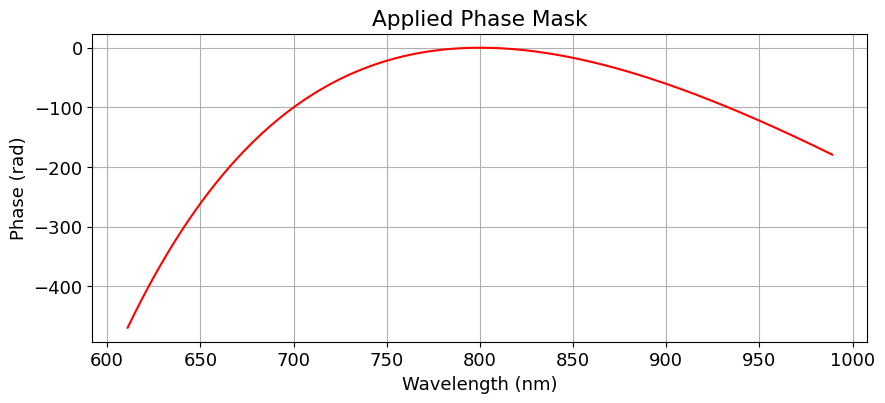

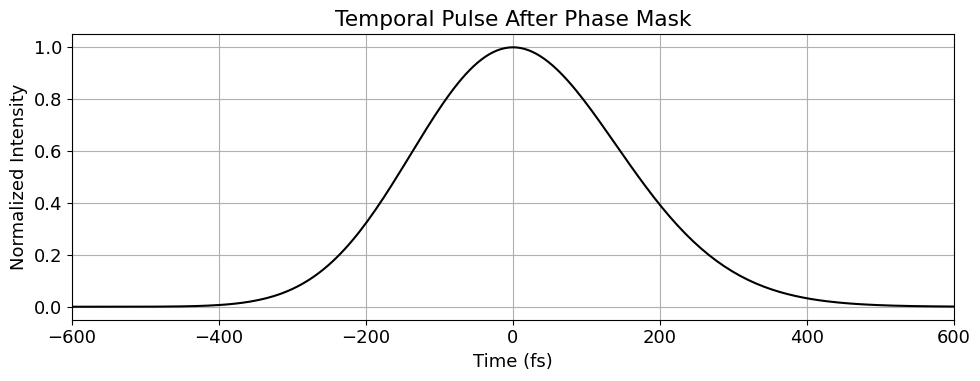

In [11]:

# --- Plot results ---
plt.figure(figsize=(10,4))


plt.plot(lambdas, phase_data, 'r')
#plt.ylim(-600,200)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Phase (rad)")
plt.title("Applied Phase Mask")
plt.grid(True)

plt.figure(figsize=(10,4))
plt.plot(t, I_t, 'k')
plt.xlabel("Time (fs)")
plt.ylabel("Normalized Intensity")
plt.title("Temporal Pulse After Phase Mask")
plt.grid(True)
plt.xlim(-600,600)

plt.tight_layout()
plt.show()

## Attempting some Analysis

Analysis of temporal width to GDD coefficient done using simulated phase and laser data, the hope is eventually that this will be extended to real phase and laser data 

In [12]:
phases = np.linspace(0,800,1000)

widths =[]
for i in range(len(phases)):

    a2 = phases[i] # s^2, adjust to see broadening
    phase_data = -(a2 * (Omega)**2)  # 

    
    phi_interp = interp1d(Omega, phase_data, kind='cubic', fill_value=2000, bounds_error=False)
   


    
    phi_omega = phi_interp(Omega_uniform)
    E_omega = A_omega * np.exp(1j * phi_omega)

    # --- Inverse Fourier Transform to time domain ---
    E_t = fftshift(ifft(fftshift(E_omega)))
    
    # --- Temporal intensity ---
    I_t = np.abs(E_t)**2
    I_t /= np.max(I_t)

    #full_width_half_max, lefts, rights, heights, dx,fwg = FWHM(t,I_t)
    fwg = FWHM_2(t,I_t)
    #print(full_width_half_max)
    widths.append(float(fwg))

    

widths =np.asarray(widths)

/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_8626/4067067672.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(phases, widths, 'k', color ='magenta')


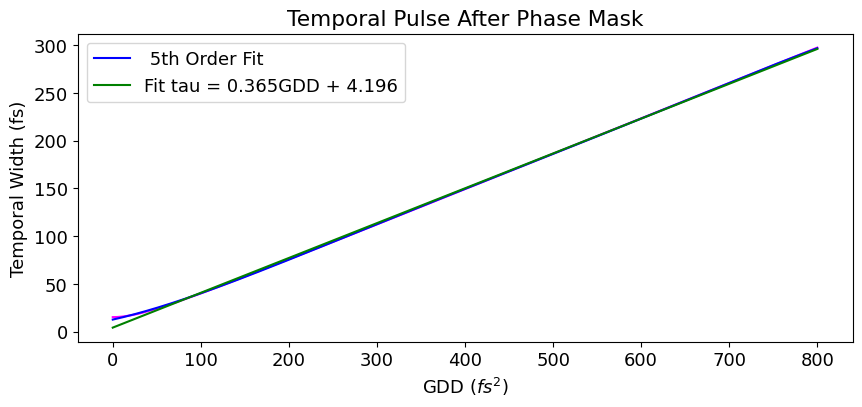

In [13]:
fit =np.polyfit(phases,widths,5)

#print(fit)
fitted = fit[0]*phases**5 + fit[1]*phases**4 + fit[2]*phases**3 + fit[3]*phases**2 + fit[4]*phases +fit[5]
#fit =np.polyfit(phases,widths,6)
#print(fit)
#fitted = fit[0]*phases**6 + fit[1]*phases**5 + fit[2]*phases**4 + fit[3]*phases**3 + fit[4]*phases**2 +fit[5]*phases + fit[6]

params2, params_covariance2 = optimize.curve_fit(linear_func, phases,widths) #Using optimiz.curve_fit to fit a straightline to the data for measured field strength 


plt.figure(figsize=(10,4))
plt.plot(phases, widths, 'k', color ='magenta')
plt.plot(phases,fitted, color ='blue', label =' 5th Order Fit')

plt.plot(phases,linear_func(phases,*params2), color='green', label ='Fit tau = {0:.3f}GDD + {1:.3f}'.format(params2[0],params2[1]))
plt.xlabel("GDD ($fs^2$)")
plt.ylabel("Temporal Width (fs)")
plt.title("Temporal Pulse After Phase Mask")
plt.legend()



plt.show()

/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_8626/2845628111.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(widths, phases, 'k', color ='magenta')
/var/folders/ch/jpgfqsp91mq7dcm3hcx5l0vc0000gn/T/ipykernel_8626/2845628111.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


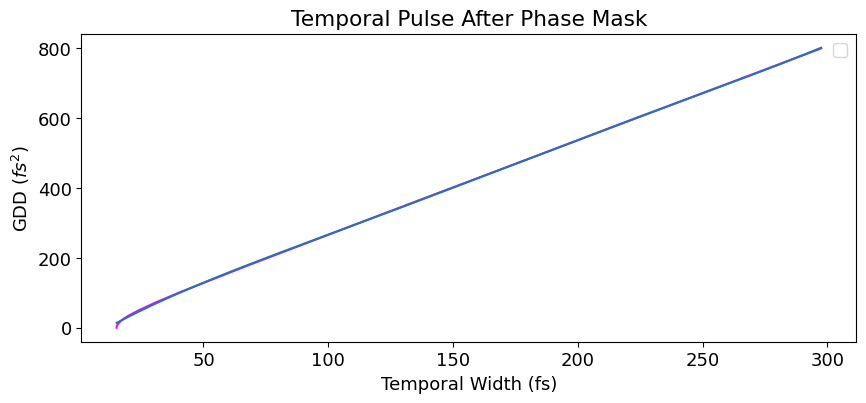

In [14]:
fit_widths =np.polyfit(widths,phases,5)

fitted_widths = fit_widths[0]*(widths)**5 + fit_widths[1]*(widths)**4 + fit_widths[2]*widths**3 + fit_widths[3]*widths**2 + fit_widths[4]*widths +fit_widths[5]

plt.figure(figsize=(10,4))
plt.plot(widths, phases, 'k', color ='magenta')
plt.plot(widths,fitted_widths)

#plt.plot(phases,linear_func(phases,*params2), color='green', label ='Fit tau = {0:.3f}GDD + {1:.3f}'.format(params2[0],params2[1]))
plt.ylabel("GDD ($fs^2$)")
plt.xlabel("Temporal Width (fs)")
plt.title("Temporal Pulse After Phase Mask")
plt.legend()


plt.show()


In [15]:
#GDD_from_time(10,params2[0],params2[1])


#tau1= time_from_GDD(0,params2[0],params2[1])

time_from_GDD_poly(0,fit[0],fit[1],fit[2],fit[3],fit[4],fit[5],widths[0])

gdd_from_time_poly(90,fit_widths[0],fit_widths[1],fit_widths[2],fit_widths[3],fit_widths[4],fit_widths[5],widths[0])
times =[15,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

You have reached the lower bound for this model hence we recover TL pulse
The time for a target GDD of 0fs^2 is 15.189 fs
The GDD for a target pulse width of 90fs is 239.880 fs^2


In [16]:
target_time =100
target_phase = 200
interp_phase = PchipInterpolator(widths, phases)
#interp_phase = interp1d(widths, phases, fill_value="extrapolate")
#interp_time = interp1d( phases, widths, fill_value="extrapolate")
interp_time = PchipInterpolator(phases, widths)
GDD = interp_phase(target_time)
tau = interp_time(target_phase)



print(GDD)
print(tau)

266.3667362609566
75.73727438628451


In [17]:
times =[15.2,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
widths4=[]
intensities4=[]
temp_profiles4=[]
dispersion4=[]
for i in range(len(times)):

    target = times[i]
    gdd1 = interp_phase(target)
    dispersion4.append(gdd1)
    a2 = gdd1 # s^2, adjust to see broadening      #note the model only works up to 470
    phase_data = -(a2 *(Omega)**2)

    # Create evenly spaced ω grid for FFT
    
    phi_interp = interp1d(Omega, phase_data, kind='cubic', fill_value=2000, bounds_error=False)
    phi_omega = phi_interp(Omega_uniform)
    E_omega = A_omega * np.exp(1j *phi_omega)

    # --- Inverse Fourier Transform to time domain ---
    E_t = fftshift(ifft(fftshift(E_omega)))
    
   

    # --- Temporal intensity ---
    I_t = np.abs(E_t)**2
    I_t /= np.max(I_t)

    
    gh4 =FWHM_2(t,I_t)

    widths4.append(float(gh4))
    intensities4.append(I_t)
    temp_profiles4.append(t)


    #print('The FWHM of the resultant temporal pulse is {0:.3f}fs'.format(float(gh4)))

[15.200107752705721, 19.99999746262954, 30.00078125841209, 40.00006067018578, 50.00000017891348, 60.00000006381312, 69.99999967904765, 79.99999983737624, 90.00000012064231, 100.00011417521497, 110.00000005437798, 119.99999993940412, 129.9999998526991, 139.99999993408315, 150.00000009353425, 160.0000000678109, 169.99999995772635, 179.99999995540847, 190.00000006893663, 199.99976671931583]


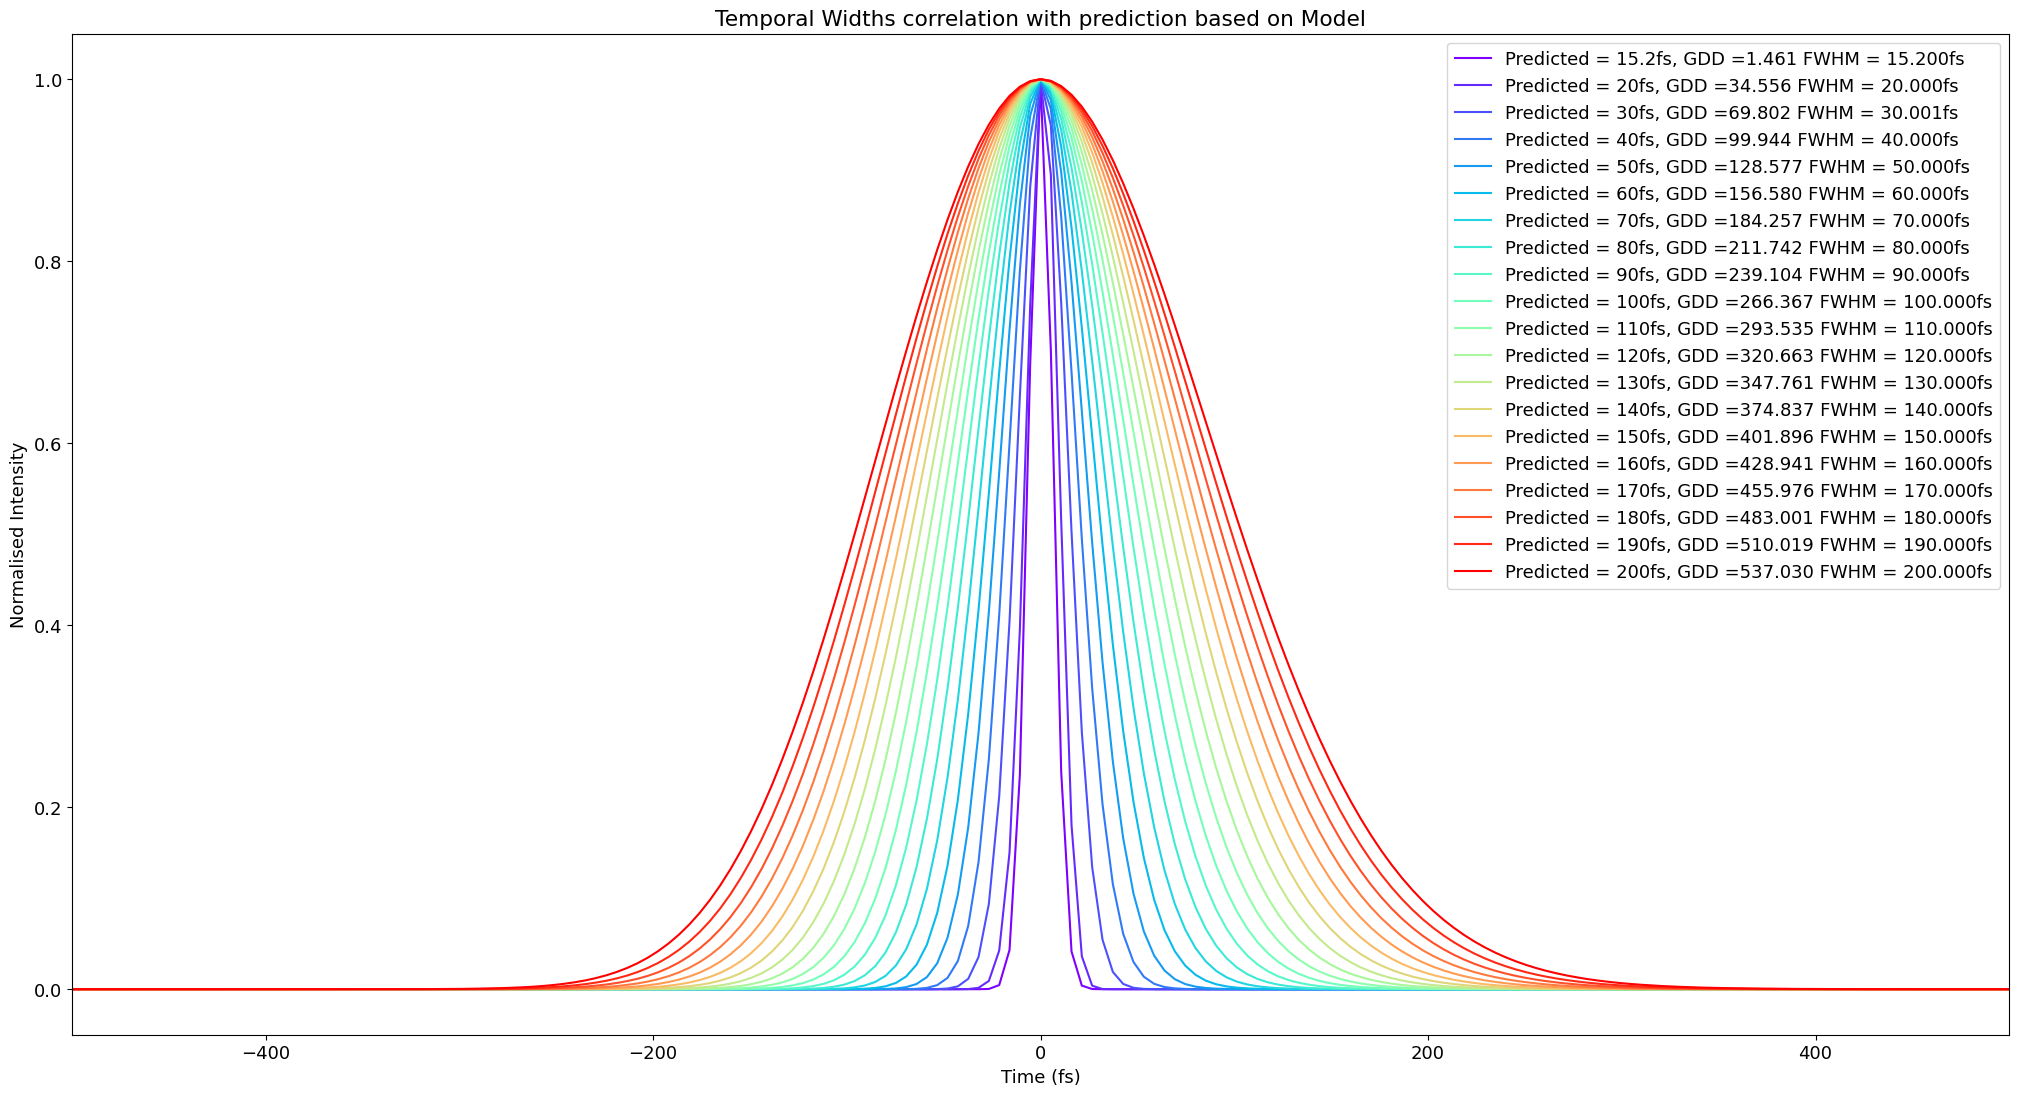

In [18]:
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(widths4))))
cmap = plt.get_cmap('rainbow', len(widths4))
print(widths4)
diffs4 =[]
for i in range(len(times)):
    diff4 = times[i]-widths4[i]
    diffs4.append(diff4)

plt.figure(figsize=(25,13))
for i in range(len(intensities4)):
    c = next(color)
    
    plt.plot(temp_profiles4[i],intensities4[i], color =c, label ='Predicted = {0}fs, GDD ={1:.3f} FWHM = {2:.3f}fs'.format(times[i],dispersion4[i],widths4[i]) )

plt.xlabel("Time (fs)")
plt.ylabel("Normalised Intensity")
plt.title("Temporal Widths correlation with prediction based on Model")
#plt.axhline(0.5)
#plt.axvline(-70.442)
#plt.axvline(70.442)
plt.legend()
plt.xlim(-500,500)
#title ='Temporal_Widths_Correlation_with_prediction_141125.png'
#plt.savefig(title)
plt.show()

In [25]:



phoses =np.linspace(0,550,30)
widths3=[]
intensities3=[]
temp_profiles3=[]
predicted_times =[]


for i in range(len(phoses)):

    
    a2 = phoses[i] # s^2, adjust to see broadening      #note the model only works up to 470
    tau1= interp_time(a2)
    predicted_times.append(tau1)
    phase_data = -(a2 *(Omega)**2)
    

    # Create evenly spaced ω grid for FFT
    
    phi_interp = interp1d(Omega, phase_data, kind='cubic', fill_value=2000, bounds_error=False)
    phi_omega = phi_interp(Omega_uniform)
    E_omega = A_omega * np.exp(1j *phi_omega)

    # --- Inverse Fourier Transform to time domain ---
    E_t = fftshift(ifft(fftshift(E_omega)))
    
    # --- Temporal intensity ---
    I_t = np.abs(E_t)**2
    I_t /= np.max(I_t)

    gh = FWHM_2(t,I_t)
    widths3.append(float(gh))
    intensities3.append(I_t)
    temp_profiles3.append(t)


    #print('The FWHM of the resultant temporal pulse is {0:.3f}fs'.format(float(gh)))

[15.188892947477402, 16.83868393095574, 20.863894918586062, 26.12990382779857, 31.97918028140735, 38.29133759021037, 44.804079038966286, 51.485930784634576, 58.26570895263238, 65.09850408028491, 71.95935002753036, 78.85863674782388, 85.81145239348865, 92.73943966327042, 99.69194092341478, 106.69135994149195, 113.65150548705411, 120.63937806097219, 127.65404411027498, 134.63198674271877, 141.64127199382835, 148.66370592035312, 155.65293053504502, 162.67600443642493, 169.70257696422786, 176.7106175369534, 183.73203452430658, 190.76086790144626, 197.78368309678154, 204.8025725679048]


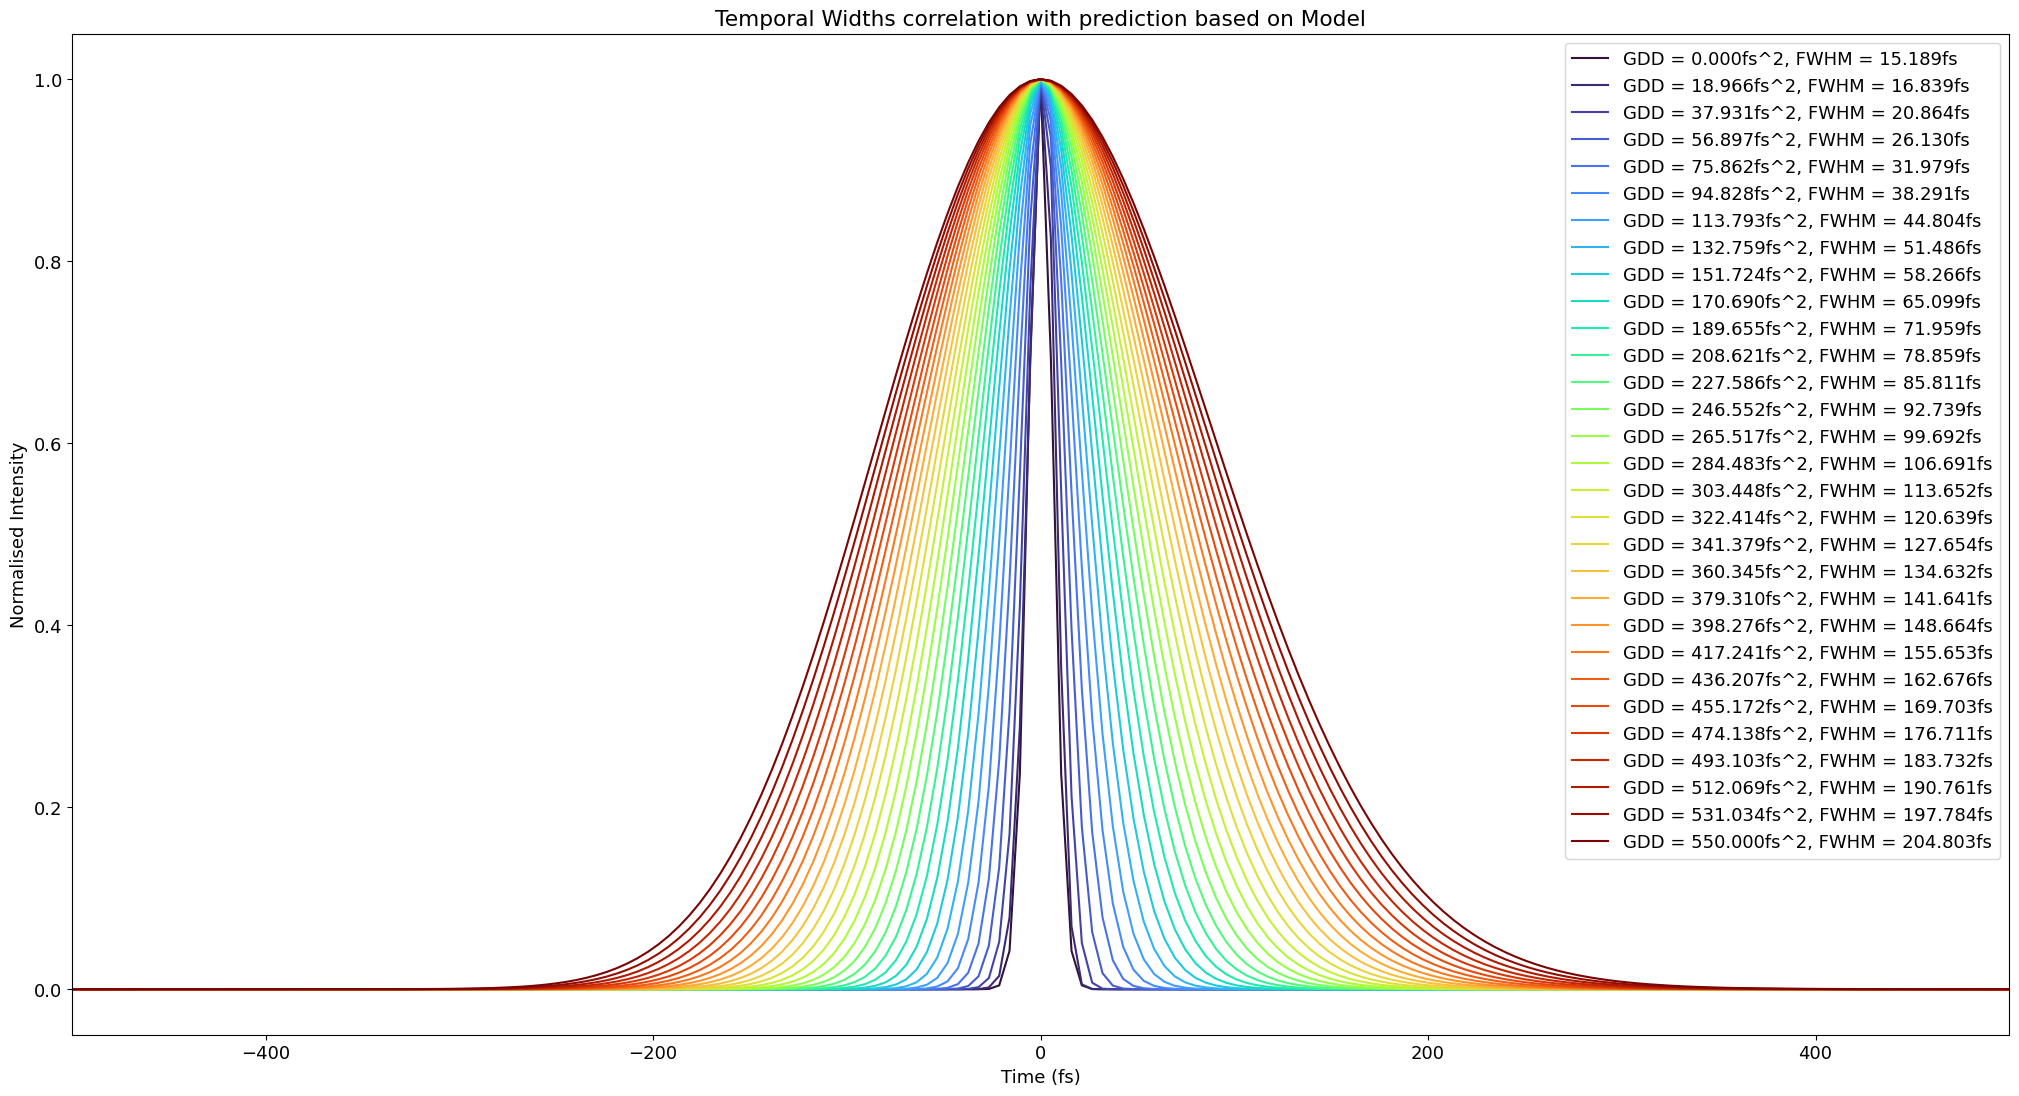

In [33]:
color = iter(plt.cm.turbo(np.linspace(0, 1, len(widths3))))
cmap = plt.get_cmap('rainbow', len(widths3))
print(widths3)

plt.figure(figsize=(25,13))
for i in range(len(intensities3)):
    c = next(color)
    plt.plot(temp_profiles3[i],intensities3[i], color =c, label ='GDD = {0:.3f}fs^2, FWHM = {1:.3f}fs'.format(phoses[i],widths3[i]) )

plt.xlabel("Time (fs)")
plt.ylabel("Normalised Intensity")
plt.title("Temporal Widths correlation with prediction based on Model")
plt.legend()
plt.xlim(-500,500)
#title ='Temporal_Widths_Correlation_with_prediction_141125.png'
#plt.savefig(title)
plt.show()